In [1]:
import pandas as pd
import json

# Read the DataFrame and parse the 'date' column as a datetime and use it as an index
df = pd.read_json('sentiment-indicator/data/indexes/dump_enhanced_all-19333_aggregated.json', convert_dates=['date'])
df.set_index('date', inplace=True)
#df = df.asfreq('D')

df = df.drop(columns=['positive_min', 'positive_max', 'negative_min', 'negative_max', 'neutral'])

df.head()

,items_per_day,positive,negative
date,,,
2016-01-02,2,0.053309,0.030194
2016-01-03,1,0.027721,0.025714
2016-01-04,5,0.049220,0.029624
2016-01-05,5,0.229310,0.034212
2016-01-06,2,0.036985,0.018114


In [2]:
# Create a new date range
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Find the missing dates by comparing the new date range with the dataframe's index
missing_dates = full_date_range.difference(df.index)

print(missing_dates)

DatetimeIndex(['2016-01-07', '2016-01-08', '2016-01-16', '2016-01-29',
               '2016-02-06', '2016-02-08', '2016-02-14', '2016-02-22',
               '2016-02-28', '2016-03-06',
               ...
               '2021-01-15', '2021-03-20', '2021-08-21', '2021-09-18',
               '2021-10-10', '2021-10-16', '2021-12-25', '2022-02-20',
               '2022-05-29', '2023-04-23'],
              dtype='datetime64[ns]', length=103, freq=None)


In [3]:
# Reindex the dataframe
df = df.reindex(full_date_range)

In [4]:
# Find the missing dates by comparing the new date range with the dataframe's index
missing_dates = full_date_range.difference(df.index)

print(missing_dates)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [5]:
# Fill missing values

# Fill 'items_per_day' with 0
df['items_per_day'].fillna(0, inplace=True)

# Find the first row where 'items_per_day' is 0
zero_item_day = df[df['items_per_day'] == 0].first_valid_index()

# Get the previous + 1, current, and next day + 1
df.loc[pd.date_range(start=zero_item_day - pd.Timedelta(days=2), end=zero_item_day + pd.Timedelta(days=2))]

,items_per_day,positive,negative
2016-01-05,5.0,0.229310,0.034212
2016-01-06,2.0,0.036985,0.018114
2016-01-07,0.0,NaN,NaN
2016-01-08,0.0,NaN,NaN
2016-01-09,1.0,0.055059,0.014738


In [6]:
# Fill 'positive', 'negative', 'neutral' with its values from from the previous day
df[['positive', 'negative']] = df[['positive', 'negative']].fillna(method='ffill')

df.loc[pd.date_range(start=zero_item_day - pd.Timedelta(days=2), end=zero_item_day + pd.Timedelta(days=2))]

,items_per_day,positive,negative
2016-01-05,5.0,0.139879,0.034212
2016-01-06,2.0,0.022561,0.018114
2016-01-07,0.0,0.022561,0.018114
2016-01-08,0.0,0.022561,0.018114
2016-01-09,1.0,0.033586,0.014738


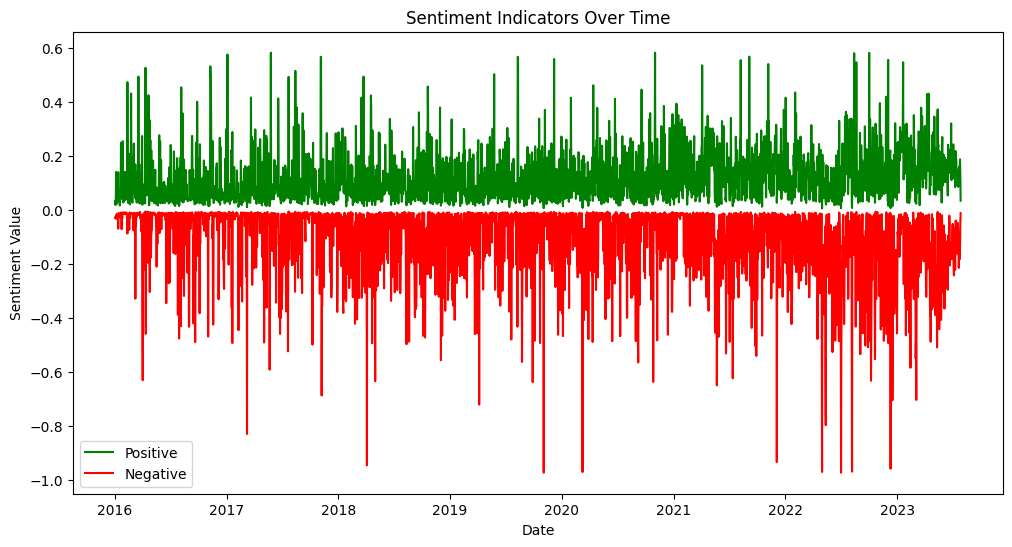

In [7]:
import matplotlib.pyplot as plt

# Plot the 'positive' and 'negative' sentiment indicators
plt.figure(figsize=(12, 6))
plt.plot(df['positive'], label='Positive', color='green')
plt.plot(-df['negative'], label='Negative', color='red')
plt.title('Sentiment Indicators Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Value')
plt.legend()
plt.show()

In [8]:
df['sentiment'] = df['positive'] - df['negative']

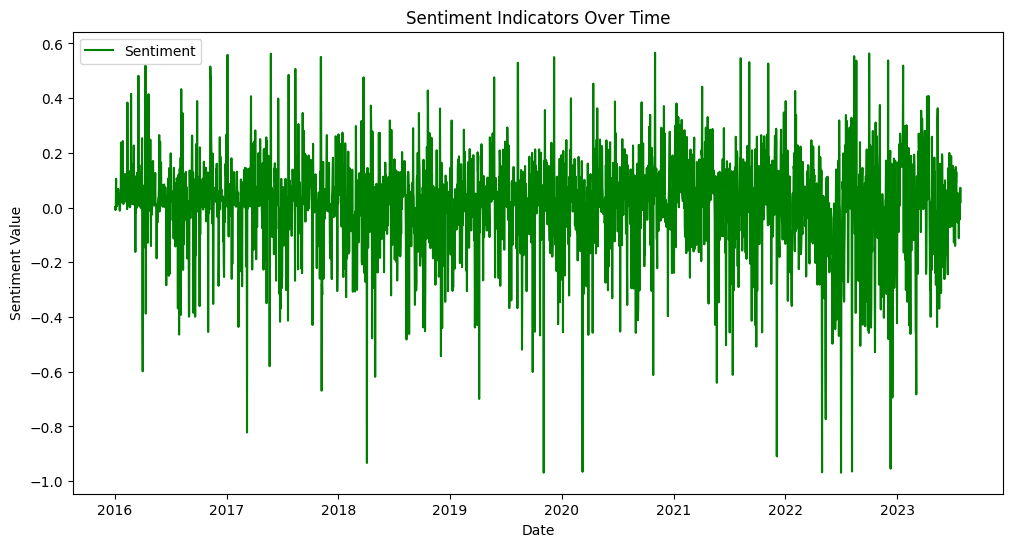

In [9]:
import matplotlib.pyplot as plt

# Plot the 'positive' and 'negative' sentiment indicators
plt.figure(figsize=(12, 6))
plt.plot(df['sentiment'], label='Sentiment', color='green')
plt.title('Sentiment Indicators Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Value')
plt.legend()
plt.show()

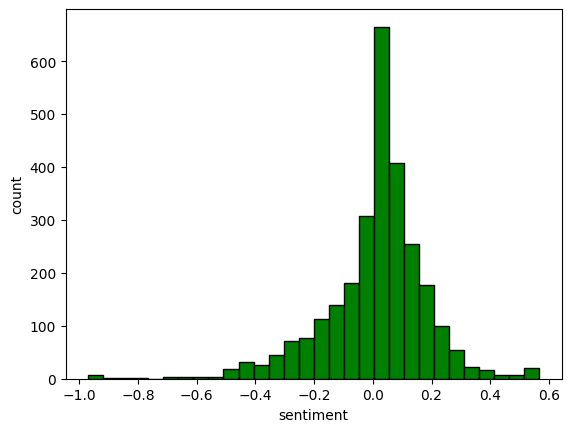

In [10]:
# Create a histogram plot of the 'sentiment' column
n, bins, patches = plt.hist(df['sentiment'], color='g', bins=30, edgecolor='black')

# Add labels to the x and y axes
plt.xlabel('sentiment')
plt.ylabel('count')

# Show the plot
plt.show()

In [11]:
print("Mean: " + str(df.sentiment.mean()))
print("Median: " + str(df.sentiment.median()))

Mean: 0.009576537773804758
Median: 0.027339076641947305


<Axes: xlabel='sentiment'>

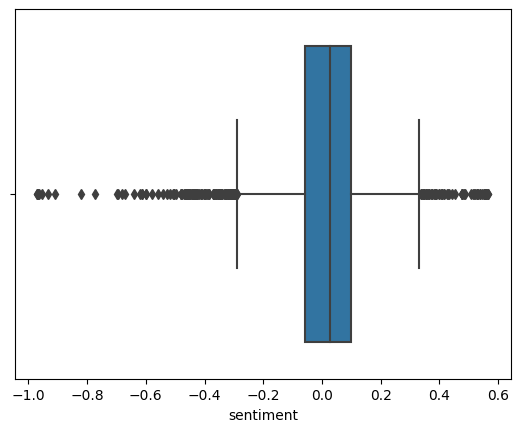

In [12]:
import seaborn as sns

sns.boxplot(x='sentiment', data=df)

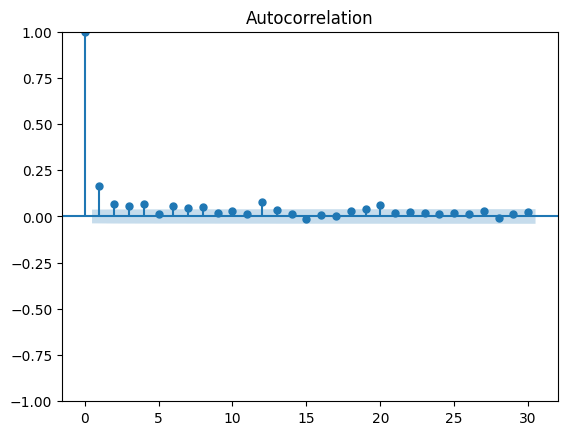

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["sentiment"], lags=30)
plt.show()

In [14]:
# It appears that the autocorrelation is significant for about 5-6 lags, after which it falls within
# the confidence intervals. This means that the sentiment score of a given day is significantly correlated
# with the sentiment scores of the preceding 5-6 days.
# After that, the correlation is not statistically significant.
# This suggests that there is a weekly pattern in the sentiment scores.

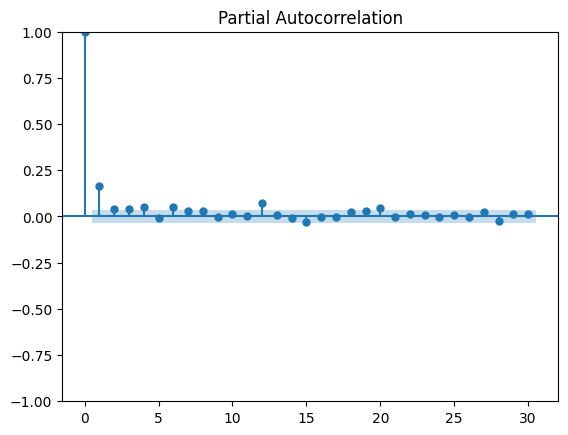

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(df["sentiment"], lags=30)
plt.show()

In [16]:
# It appears that the partial autocorrelation is significant for about 1-2 lags, after which it falls
# within the confidence intervals. This means that the sentiment score of a given day is significantly
# influenced by the sentiment scores of the preceding 1-2 days, after adjusting for other lags.
# After that, the influence is not statistically significant.

<Axes: >

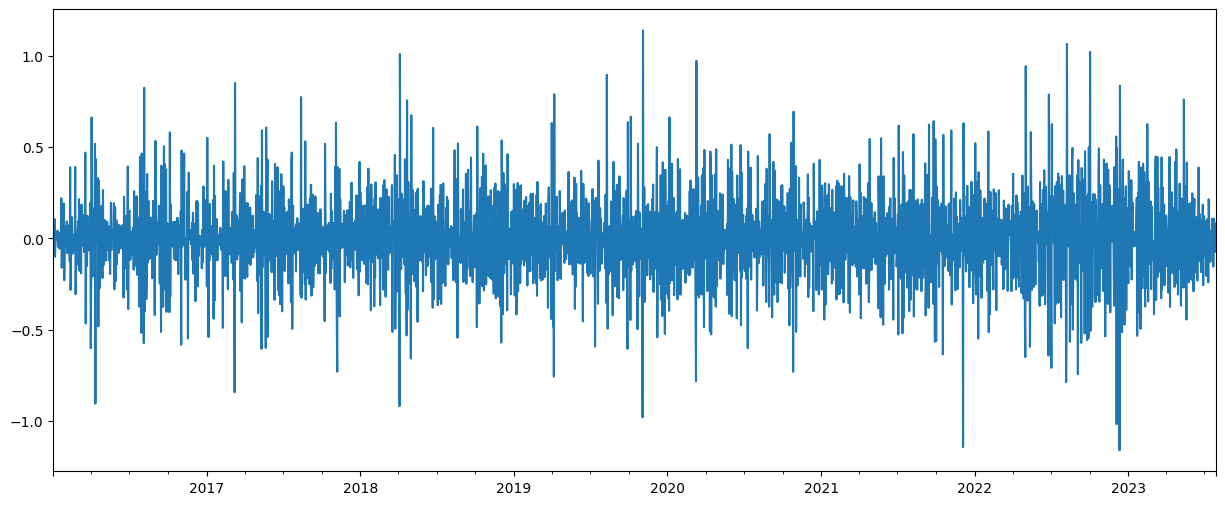

In [17]:
df.sentiment.diff().plot(figsize=(15,6))

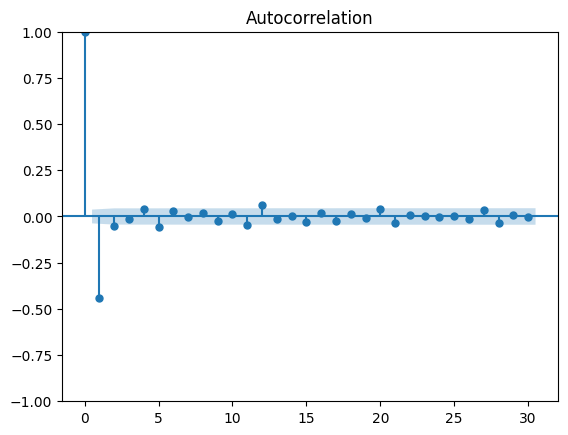

In [18]:
plot_acf(df["sentiment"].diff().dropna(),lags=30)
plt.show()

In [19]:
# Most of the autocorrelation coefficients fall within the blue shaded area, which represents the confidence
# intervals. If the autocorrelation is within this area, it is not statistically significantly different
# from zero.Therefore, most of the autocorrelation coefficients are not statistically significant.
#
# This could suggest that the series, once differenced, is close to a white noise series - a series where values
# are not predictable based on previous values and there is no obvious trend or seasonality.
# This is a common characteristic of stationary time series, which are often desirable when building
# time series models.

<Axes: xlabel='sentiment', ylabel='Density'>

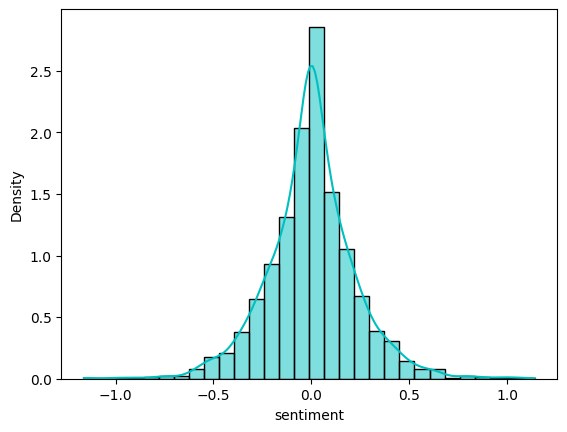

In [20]:
from scipy.stats import norm

sns.histplot(df.sentiment.diff(), kde=True, stat="density", color='c', bins=30)

In [21]:
# Add 'positive' to 'negative' * -1 for each day
df['sentiment'] = df['positive'] + (df['negative'] * -1)

# Accumulate the values
df['sentiment_cumulative'] = df['sentiment'].cumsum()

df = df.drop(columns=['sentiment', 'items_per_day', 'positive', 'negative'])

df.head()

,sentiment_cumulative
2016-01-02,0.002324
2016-01-03,-0.006480
2016-01-04,-0.006080
2016-01-05,0.099588
2016-01-06,0.104035


<Axes: >

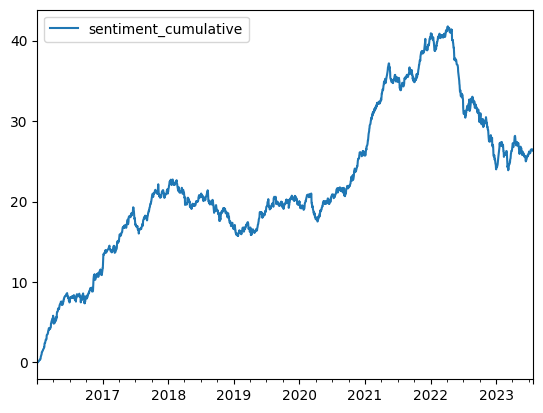

In [22]:
df.plot()

In [23]:
# Save DataFrame as a JSON file
df.to_json('sentiment_dataframe.json')